In [1]:
import pandas as pd
import numpy as np
import copy
import time
import matplotlib.pyplot as plt
import time
starttime = time.perf_counter()
import warnings
warnings.filterwarnings('ignore')

In [19]:
class MT:
    
    def __init__(self, Seed, Number_Of_Students, Number_Of_Pref):
        self.Number_Of_Students = Number_Of_Students
        self.Number_Of_Pref     = Number_Of_Pref
        self.Number_of_School   = self.Number_Of_Pref 
        self.Type_List          = ["Social","Math", "Language"]
        self.Seed               = Seed
        
    def school_information_tables(self):
        np.random.seed(self.Seed)
        school = np.arange(1,self.Number_of_School + 1)   #number of school / same with pref
        school_list = ["C"+str(i) for i in school]

        # Random quotas for school ------------------    
        while True:

            random_quota_list = np.random.multinomial(self.Number_Of_Students, [1/int(self.Number_Of_Pref)]*self.Number_Of_Pref, size=1)
            quota_list = random_quota_list[0]

            if 0 in quota_list:
                continue
            else:
                break

        sch_info = pd.DataFrame(index = school_list, columns=["Quota","School Type"])
        sch_info["Quota"] = quota_list

        School_Type = self.Type_List.copy()

        while len(School_Type) < len(sch_info.index):
            random_variable = np.random.randint(0,len(self.Type_List))
            School_Type.append(self.Type_List[random_variable])

        sch_info["School Type"] = School_Type    
        sch_info_SD = sch_info.T
        
        sch_info_school = copy.deepcopy(sch_info_SD)
        sch_info_school.loc["Assigments"] = [[] for k in range(self.Number_of_School)]
        
        sch_info_student = copy.deepcopy(sch_info_SD)
        sch_info_student.loc[1] = [[] for k in range(self.Number_of_School)]

        return [sch_info_SD, sch_info_school, sch_info_student]
    
    def student_information_table(self):     
        std_info = pd.DataFrame(columns =["S"+ str(std) for std in range(1,self.Number_Of_Students+1)])
        std_info.loc[1] = [[] for k in range(self.Number_Of_Students)]
        return std_info
        
    def student_scores(self):
        np.random.seed(self.Seed)
        score_table = pd.DataFrame(index = ["S"+ str(std) for std in range(1,self.Number_Of_Students+1)], \
                                        columns = self.Type_List) #number of Types

        for a in score_table.index:
            for b in score_table.columns:
                score_table.at[a,b]= np.random.uniform(150,500) 
        return score_table    

    def student_order(self):
        std_order_table = pd.DataFrame(index = range(1, self.Number_Of_Students + 1), columns = self.Type_List)

        for typ in std_order_table.columns:
            type_columns = self.student_scores().sort_values(typ, ascending = False)
            std_order_table[typ] = type_columns.index

        return std_order_table  

    def student_prefs(self):
        np.random.seed(self.Seed)
        
        students = np.arange(1,self.Number_Of_Students+1) #number of student   
        std_pref = pd.DataFrame(index = range(1, self.Number_Of_Pref+2))
        
        for std in students:
    
            pref_list = []

            while len(pref_list) < self.Number_Of_Pref+1:    #number of pref
                pref = np.random.randint(0,self.Number_Of_Pref+1)    #number of pref
                if "C" + str(pref) in pref_list:
                    continue
                else: 
                    pref_list.append(("C" + str(pref)))
                    if pref_list[0] == "C0":
                        del pref_list[0]

            std_pref["S"+ str(std)] = pref_list

        return std_pref

    def school_prefs(self):
        sch_info = self.school_information_tables()[0]
        type_dict = {}

        for col in sch_info.columns:
            type_dict[col] = sch_info.loc["School Type", col]

        sch_pref = pd.DataFrame(columns = sch_info.columns, index = range(1, self.Number_Of_Students+1))
        for school in sch_pref.columns:
            school_type = type_dict[school]
            values = self.student_order()[school_type].values
            sch_pref[school] = values

        sch_pref.loc[self.Number_Of_Students + 1] = ["S0" for k in range(self.Number_Of_Pref)]
        
        return sch_pref

    def auxiliary_data_table_sch(self):
        sch_pref = self.school_prefs()
        std_pref = self.student_prefs()
        
        sch_std_pref_table = pd.DataFrame(index = sch_pref.index, columns = sch_pref.columns)

        # Tüm hücrelere boş sözlük atanaması
        for row in sch_std_pref_table.index:
            sch_std_pref_table.loc[row] = [ {} for i in range(self.Number_of_School)] 

        for col in sch_pref.columns:

            for row in sch_pref.index:
                
                student = sch_pref.loc[row, col]                 

                if student == "S0":
                    sch_std_pref_table.loc[row, col][student] = [row]
                    continue

                S0_index       = pd.Index(sch_pref[col]).get_loc("S0") + 1
                sch_pref_index = pd.Index(sch_pref[col]).get_loc(student) + 1

                C0_index       = pd.Index(std_pref[student]).get_loc("C0") + 1
                std_pref_index = pd.Index(std_pref[student]).get_loc(col) + 1

                if std_pref_index < C0_index:
                    index = std_pref_index
                else:
                    index = 0


                if sch_pref_index < S0_index:


                    sch_std_pref_table.loc[row, col][student] = [index, row, col]

                else:
                    sch_std_pref_table.loc[row, col]["S0"] = [row]

        return sch_std_pref_table
    
    def auxiliary_data_table_std(self):
        
        sch_pref = self.school_prefs()   
        std_pref = self.student_prefs()  
        
        
        std_sch_pref_table = pd.DataFrame(index = std_pref.index, columns = std_pref.columns)

        for row in std_sch_pref_table.index:
            std_sch_pref_table.loc[row] = [ {} for i in range(self.Number_Of_Students)]


        for col in std_pref.columns:

            for row in std_pref.index:

                school = std_pref.loc[row, col]

                if school == "C0":
                    std_sch_pref_table.loc[row, col][school] = [row]
                    continue

                S0_index   = pd.Index(sch_pref[school]).get_loc("S0") + 1
                pref_index = pd.Index(sch_pref[school]).get_loc(col) + 1

                if pref_index < S0_index:
                    index = pref_index
                else:
                    index = 0

                std_sch_pref_table.loc[row, col][school] = [index, row, col]

        for col in std_sch_pref_table.columns: 

            dictionary = {}

            for row in std_sch_pref_table.index:

                school = std_sch_pref_table.loc[row, col]

                dictionary.update(school)

            C0_index = dictionary["C0"][0]

            for row in std_sch_pref_table.index:

                schandpref = std_sch_pref_table.loc[row, col]
                sch = list(schandpref.keys())[0]

                if len(list(schandpref.values())[0]) > 1 and list(schandpref.values())[0][1] > C0_index:

                    std_sch_pref_table.loc[row, col][sch][1] = 0   

        return std_sch_pref_table 
    
    def Serial_Dictatorship(self):
        m_round = 1
        assigment_list = []
        sch_info_SD        = self.school_information_tables()[0]
        std_order_table_SD = self.student_order()
        std_pref_table_SD  = self.student_prefs()
        while True:

            sch_info_SD.loc[m_round] = [[] for k in range(len(sch_info_SD.columns))]

            for sch_type in std_order_table_SD.columns:


                for std_order in std_order_table_SD.index:

                    student = std_order_table_SD.loc[std_order, sch_type]


                    for std_pref in std_pref_table_SD[student]:

                        # mevcut tercih C0 ise sonraki öğrenciye geç.-----
                        if std_pref == "C0":    
                            break

                        # mevcut tercihe ait okul tipi başlangıçtan gelen sch_type'ye
                        # eşit değilse sonraki tercihe geç.
                        current_school_type = sch_info_SD.loc["School Type", std_pref]               
                        if current_school_type != sch_type:    
                            continue                          


                        # mevcut std_pref yani okula ait açık otayı kontrol et !!!!
                        # Eğer açık kota varsa atamayı yap.               

                        quota           = sch_info_SD.loc["Quota", std_pref]
                        numberOfStudent = len(sch_info_SD.loc[m_round, std_pref])

                        if quota > numberOfStudent:

                            current_pref_index = pd.Index(std_pref_table_SD[student]).get_loc(std_pref) + 1
                            assig_std_inf = {student: [std_pref,current_pref_index]}
                            sch_info_SD.loc[m_round,std_pref].append(assig_std_inf)
                            assigment_list.append(assig_std_inf)
                            break

            # İlk tur atamaları yapıldıktan sonra !!!! tüm öğrenciler için  
            # atandıkları okul sonrasındaki tercihler C0 yapıldı.     

            for ass in assigment_list:

                student1           = list(ass.keys())[0]
                preference1        = list(ass.values())[0][0]
                preference_order1  = list(ass.values())[0][1]

                for col in std_pref_table_SD.columns:

                    if col == student1:

                        for row in std_pref_table_SD.index:

                            preference2 = std_pref_table_SD.loc[row, col]
                            preference_order2 = row

                            if preference_order1 < preference_order2:
                                std_pref_table_SD.loc[row, col] = "C0"


            # Bir önceki atamalar ile bu turdaki atamaları karşılaştır. 
            # Aynı atamalar yapıldı ise son yapılam atamaları sil ve döngüyü durdur. 

            if m_round > 1:

                previous_assigments = list(sch_info_SD.loc[m_round - 1])
                current_assigments  = list(sch_info_SD.loc[m_round])

                if previous_assigments == current_assigments:
                    sch_info_SD = sch_info_SD[:-1]

                    #SCH INFO DAHA SADE BİR ŞEKİLDE SCH INFO UPDATE TABLOSUNA DÖNÜŞTÜRÜLÜYOR. 
                    sch_info_update_SD = copy.deepcopy(sch_info_SD)
                    for col in sch_info_update_SD.columns:
                        for row in sch_info_update_SD.index[2:]:
                            sch_info_update_SD.loc[row, col] = []

                    for col in sch_info_SD.columns:
                        for row in sch_info_SD.index[2:]:
                            ass = sch_info_SD.loc[row, col]
                            if len(ass) > 0:

                                for x in ass:
                                    student = list(x.keys())[0]
                                    order   = list(x.values())[0][1]

                                    value = (student, order)

                                    sch_info_update_SD.loc[row, col].append(value)

                    break


            m_round += 1

        return sch_info_update_SD

    def GS_School_Optimal(self):
        m_round = 1
        sch_std_pref_table   = self.auxiliary_data_table_sch()
        sch_info_sch         = self.school_information_tables()[1]
        std_info             = self.student_information_table()
        while True:

            # Okulların mevcut kotalarına göre tercih listelerinin school_prefs 
            # listesinin içerisine atanması
            for school in sch_std_pref_table.columns:

                if m_round > 1 and  school not in refused_school:
                    continue

                school_pref_list = [pref for pref in list(sch_std_pref_table[school]) if pref != 0]
                school_quota     = sch_info_sch.loc["Quota", school] - len(sch_info_sch.loc["Assigments", school])
                school_prefs     = school_pref_list[:(school_quota)]


                # school_prefs listesi içerisindeki okul tercihlerine göre
                # ilgili öğrencilere tercihlerin iletilmesi
                for preferred_student in school_prefs:

                    student            = list(preferred_student.keys())[0]
                    if student == "S0":
                        break

                    student_pref_order = list(preferred_student.values())[0][0]
                    value = (school, student_pref_order, student)
                    std_info.loc[m_round, student].append(value)
                    sch_info_sch.loc["Assigments", school].append((student))   #Kota kontrolü için okullara da atama yapılıyor. 


                # Teklif yapan okulların yapmış oldukları teklifler için 
                # sch_std_pref_table tablasunun güncellenmesi

                school_pref_list2 = [pref for pref in list(sch_std_pref_table[school])]

                count_0 = school_pref_list2.count(0)
                count = 0

                for x in range(school_quota):

                    if (count_0 + x) > len(school_pref_list2)-1:
                        break
                    school_pref_list2[count_0 + x] = 0



                sch_std_pref_table[school] = school_pref_list2

            # Teklif yapan okulların öğrenci tercih sırasına göre sıralanması
            # İlgili okul Öğrenci tercihlerinde C0'dan sonra ise öğrenci tercih sırası 0 oluyor.

            for student in std_info.columns:
                std_info.loc[m_round, student] = sorted(std_info.loc[m_round, student], 
                                                        key = lambda e: e[1])         

            # Teklifleri reddedilen ve geçici kabul edilen öğrencilerin 
            # bilgilierinin iki ayrı liste şeklinde elde edilmesi

            refused_school  = []
            accepted_school = []

            for student in std_info.columns:

                list1 = []
                biddings = std_info.loc[m_round, student]


                if len(biddings) == 0:
                    accepted_school.append([])
                    continue

                if len(biddings) == 1:

                    if biddings[0][1] == 0:

                        refused_school.append(biddings[0])
                        accepted_school.append([])
                    else:
                        list1.append(biddings[0])
                        accepted_school.append(list1)

                if len(biddings) > 1:

                    if biddings[0][1] != 0:
                        list1.append(biddings[0])
                        accepted_school.append(list1)
                        refused_school.extend(biddings[1:])
                        continue

                    else:

                        for bid in biddings:

                            if bid[1] == 0:
                                refused_school.append(bid)
                            else:
                                list1.append(bid)
                                accepted_school.append(list1)

                                index = biddings.index(bid)
                                refused_school.extend(biddings[index+1:])
                                break

                        # Tekliflerin hepsinin öğrenci tarafından
                        # reddedilme durumu
                        except_0 = 0  # Teklifler içerisinde 0 hariç olanlar için sayaç
                        for bid in biddings:
                            if bid[1] == 0:
                                continue
                            else:
                                except_0 +=1

                        if except_0 == 0:  # Sayaç 0'a eşit ise tüm teklifler 0 demektir. KAbul edilen okullara [] ekle.
                            accepted_school.append([])

                        #-----------------------------------------

            if accepted_school == list(std_info.loc[m_round]):

                std_info_update = copy.deepcopy(std_info)

                for col in std_info_update.columns:
                        for row in std_info_update.index:
                            std_info_update.loc[row, col] = []    

                for col in std_info.columns:
                    for row in std_info.index:

                        ass = std_info.loc[row, col]

                        if len(ass) > 0:

                            for x in ass:
                                school = x[0]
                                order  = x[1]

                                value = (school, order)

                                std_info_update.loc[row, col].append(value)
                break

            else:
                std_info.loc[m_round + 1] = [[] for k in range(self.Number_Of_Students)]
                std_info.loc[m_round + 1] = accepted_school


            # Reddedilen okulların kotalarının güncellenmesi
            for refused in refused_school:
                res_school = refused[0]
                std        = refused[2]
                sch_info_sch.loc["Assigments",res_school ].remove(std)

            # refused_school listesinin sadece okulları içerecek şekilde 
            # güncellenmesi, çünkü kad satırın başlangıcındaki şarta uyum sağlanması gerekiyor.
            for k in range(len(refused_school)):
                refused_school[k] =  refused_school[k][0] 

            m_round +=1


#         gs_school_pref_result =  copy.deepcopy(sch_info_sch)   
        return (std_info_update, sch_info_sch)

    def GS_Student_Optimal(self):
        sch_info2          = self.school_information_tables()[2]
        std_sch_pref_table = self.auxiliary_data_table_std()
        for student in std_sch_pref_table.columns:  # S1, S2, S3, S4, S5 ......

            studentPref = std_sch_pref_table.loc[1, student]
            school      = list(studentPref.keys())[0]
            stdpref     = list(studentPref.values())[0][1]
            schpref     = list(studentPref.values())[0][0]

            sch_info2.loc[1, school].append({student: [stdpref, schpref, school]})
            sch_info2.loc[1, school] = sorted(sch_info2.loc[1,school], key = lambda e: list(e.values())[0][1])


        del_list = [] 
        for school in sch_info2.columns:  # C1, C2, C3, ......üzerinde dolaşıyor.

            del_list2 = []
            placed = sch_info2.loc[1, school]

            for std_s0 in placed:

                if list(std_s0.values())[0][1] == 0:

                    del_list2.append(std_s0)


            numberofstudent = len(placed)
            exceptS0student = numberofstudent - len(del_list2)
            quota           = sch_info2.loc["Quota", school]
            excessquota     = exceptS0student - quota

            for i in range(excessquota):

                del_list2.append(placed[-(i+1)])

            del_list.append(del_list2)

        
        model_round = 2
       

        while True:

            Current_Placed = []

            for col in sch_info2.columns:
                p_placed = sch_info2.loc[model_round - 1, col]
                Current_Placed.append(p_placed)


            New_Placed = []    
            for x in range(len(Current_Placed)):

                if len(Current_Placed[x]) > 0:

                    p_placed = Current_Placed[x]
                    d_list   = del_list[x]
                    n_placed = [k for k in p_placed if k not in d_list]
                    New_Placed.append(n_placed)

                else:
                    New_Placed.append(Current_Placed[x])

            if Current_Placed == New_Placed:

                sch_info_update2 = copy.deepcopy(sch_info2)
                for col in sch_info_update2.columns:
                        for row in sch_info_update2.index[2:]:
                            sch_info_update2.loc[row, col] = []    

                for col in sch_info2.columns:
                    for row in sch_info2.index[2:]:
                        ass = sch_info2.loc[row, col]
                        if len(ass) > 0:
                            for x in ass:
                                student = list(x.keys())[0]
                                order   = list(x.values())[0][0]

                                value = (student, order)

                                sch_info_update2.loc[row, col].append(value)

                break

            else:

                new_row = [ [] for s in range(self.Number_of_School)]
                sch_info2.loc[model_round] = new_row

                # New Placed'i yukarıda oluşturulan yeni satıra ekliyoruz.
                for x in New_Placed:

                    if len(x) > 0:

                        for y in x:
                            school = list(y.values())[0][2]
                            sch_info2.loc[model_round, school].append(y)


                # Del list'in içindekiler için sonraki tercihlerine atama yapılması
                for k in del_list:

                    if len(k) > 0:

                        for t in k:
                            n_pref_order = list(t.values())[0][0] + 1
                            student      = list(t.keys())[0]
                            n_pref       = std_sch_pref_table.loc[n_pref_order, student]

                            if list(n_pref.keys())[0] == "C0":
                                continue

                            else:
                                sch = list(n_pref.keys())[0]
                                school_pref = list(n_pref.values())[0][0]
                                n_placed = {student: [n_pref_order, school_pref, sch]}
                                sch_info2.loc[model_round, sch].append(n_placed)
                                sch_info2.loc[model_round, sch] = sorted(sch_info2.loc[model_round, sch], \
                                                                   key = lambda e: list(e.values())[0][1])

                del_list = [] 


                for school in sch_info2.columns:  # C1, C2, C3, ......üzerinde dolaşıyor.

                    del_list2 = []
                    placed = sch_info2.loc[model_round, school]


                    for std_s0 in placed:

                        if list(std_s0.values())[0][1] == 0:

                            del_list2.append(std_s0)


                    numberofstudent = len(placed) 
                    exceptS0student = numberofstudent - len(del_list2)
                    quota           = sch_info2.loc["Quota", school]
                    excessquota     = exceptS0student - quota


                    for i in range(excessquota):

                        del_list2.append(placed[-(i+1)])

                    del_list.append(del_list2)

            model_round += 1

        return sch_info_update2
    
    def model_results(self):
        
        list_gs = []
        gale_shapey_std = self.GS_Student_Optimal()
        y = list(gale_shapey_std.loc[gale_shapey_std.index[-1]])
        for util_gs in y:
            if len(util_gs) > 0:
                for ass_gs in util_gs:
                    std_order_gs = ass_gs[1]

                    stdu_gs = 1 / std_order_gs
                    list_gs.append(stdu_gs)
        TU_gs = round((sum(list_gs) / model.Number_Of_Students),3 )

        list_sd = []
        serial = self.Serial_Dictatorship()
        x = list(serial.loc[serial.index[-1]])
        for util_sd in x:
            if len(util_sd) > 0:
                for ass_sd in util_sd:
                    std_order_sd = ass_sd[1]

                    stdu_sd = 1 / std_order_sd
                    list_sd.append(stdu_sd)
        TU_sd = round((sum(list_sd) / model.Number_Of_Students),3 )
        
        
        list_gs2 = []
        gale_shapey_sch = self.GS_School_Optimal()[0]
        y = list(gale_shapey_sch.loc[gale_shapey_sch.index[-1]])
        
        for util_gs2 in y:
            if len(util_gs2) > 0:
                for ass_gs2 in util_gs2:
                    std_order_gs2 = ass_gs2[1]
                    stdu_gs2 = 1 / std_order_gs2
                    list_gs2.append(stdu_gs2)
        TU_gs2 = round((sum(list_gs2) / model.Number_Of_Students),3)
        result = {"Gale_Shapey Student Optimal Utility Level":TU_gs,
                  "GSerial Dictatorship Utility Level" :TU_sd,
                  "Gale_Shapey School Optimal Utility Level": TU_gs2 }
        
        return result
        

In [23]:
model = MT(94, 100, 10)
# model.student_scores()
# model.student_order()
# model.student_prefs()
# model.school_prefs()
# model.Serial_Dictatorship()
# model.GS_School_Optimal()[1]
model.GS_Student_Optimal()
# model.model_results()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10
Quota,12,10,11,9,9,9,10,7,16,7
School Type,Social,Math,Language,Math,Language,Social,Language,Math,Social,Language
1,"[(S81, 1), (S39, 1), (S58, 1), (S91, 1), (S66,...","[(S97, 1), (S1, 1), (S12, 1), (S2, 1), (S75, 1...","[(S70, 1), (S80, 1), (S41, 1), (S24, 1), (S68,...","[(S22, 1), (S90, 1), (S53, 1), (S63, 1), (S60,...","[(S7, 1), (S88, 1), (S55, 1), (S93, 1), (S77, ...","[(S95, 1), (S56, 1), (S28, 1), (S89, 1), (S96,...","[(S14, 1), (S21, 1), (S65, 1), (S8, 1), (S57, ...","[(S40, 1), (S94, 1), (S45, 1), (S18, 1), (S67,...","[(S49, 1), (S15, 1), (S61, 1), (S5, 1), (S6, 1...","[(S16, 1), (S98, 1), (S31, 1), (S99, 1), (S10,..."
2,"[(S81, 1), (S39, 1), (S58, 1), (S91, 1), (S66,...","[(S97, 1), (S1, 1), (S47, 2), (S12, 1), (S2, 1...","[(S71, 2), (S70, 1), (S80, 1), (S41, 1), (S36,...","[(S22, 1), (S90, 1), (S53, 1), (S63, 1), (S60,...","[(S85, 2), (S7, 1), (S88, 1), (S55, 1), (S93, ...","[(S95, 1), (S56, 1), (S28, 1), (S89, 1), (S96,...","[(S14, 1), (S72, 2), (S21, 1), (S65, 1), (S8, ...","[(S40, 1), (S94, 1), (S45, 1), (S18, 1), (S67,...","[(S49, 1), (S15, 1), (S61, 1), (S5, 1), (S6, 1...","[(S3, 2), (S16, 1), (S98, 1), (S31, 1), (S99, ..."
3,"[(S81, 1), (S39, 1), (S58, 1), (S91, 1), (S66,...","[(S97, 1), (S1, 1), (S47, 2), (S12, 1), (S2, 1...","[(S71, 2), (S70, 1), (S80, 1), (S41, 1), (S36,...","[(S22, 1), (S90, 1), (S53, 1), (S63, 1), (S60,...","[(S85, 2), (S7, 1), (S88, 1), (S55, 1), (S93, ...","[(S95, 1), (S56, 1), (S28, 1), (S89, 1), (S96,...","[(S14, 1), (S72, 2), (S21, 1), (S65, 1), (S8, ...","[(S40, 1), (S94, 1), (S45, 1), (S18, 1), (S67,...","[(S49, 1), (S15, 1), (S61, 1), (S5, 1), (S6, 1...","[(S3, 2), (S16, 1), (S98, 1), (S31, 1), (S99, ..."
4,"[(S81, 1), (S39, 1), (S58, 1), (S91, 1), (S66,...","[(S97, 1), (S1, 1), (S47, 2), (S12, 1), (S2, 1...","[(S71, 2), (S70, 1), (S80, 1), (S41, 1), (S36,...","[(S22, 1), (S90, 1), (S53, 1), (S63, 1), (S60,...","[(S85, 2), (S7, 1), (S88, 1), (S55, 1), (S93, ...","[(S95, 1), (S56, 1), (S28, 1), (S89, 1), (S96,...","[(S14, 1), (S72, 2), (S21, 1), (S65, 1), (S8, ...","[(S40, 1), (S94, 1), (S45, 1), (S18, 1), (S67,...","[(S49, 1), (S15, 1), (S61, 1), (S5, 1), (S6, 1...","[(S3, 2), (S16, 1), (S98, 1), (S31, 1), (S99, ..."
5,"[(S81, 1), (S39, 1), (S58, 1), (S91, 1), (S66,...","[(S97, 1), (S1, 1), (S47, 2), (S12, 1), (S2, 1...","[(S71, 2), (S70, 1), (S80, 1), (S41, 1), (S36,...","[(S22, 1), (S90, 1), (S53, 1), (S63, 1), (S60,...","[(S85, 2), (S7, 1), (S88, 1), (S55, 1), (S93, ...","[(S95, 1), (S56, 1), (S28, 1), (S89, 1), (S96,...","[(S14, 1), (S72, 2), (S21, 1), (S65, 1), (S8, ...","[(S40, 1), (S94, 1), (S45, 1), (S18, 1), (S67,...","[(S49, 1), (S15, 1), (S61, 1), (S5, 1), (S6, 1...","[(S3, 2), (S16, 1), (S98, 1), (S31, 1), (S99, ..."


In [26]:
Values = []
seeds = (3,5,8,9,15,18,20,22,23,24,26,28,38,39,47,51,53,55,56,59,62,66,74,77,81,89,90,94,95,98)

for k in seeds:
    model = MT(k, 100,10)
    serial      = model.model_results()["GSerial Dictatorship Utility Level"]
    school_opt  = model.model_results()["Gale_Shapey School Optimal Utility Level"]
    student_opt = model.model_results()["Gale_Shapey Student Optimal Utility Level"]
    Values.append([serial,school_opt,student_opt  ])
Values

[[0.85, 0.85, 0.868],
 [0.842, 0.842, 0.865],
 [0.856, 0.856, 0.868],
 [0.786, 0.786, 0.8],
 [0.8, 0.8, 0.812],
 [0.833, 0.833, 0.845],
 [0.863, 0.863, 0.877],
 [0.738, 0.738, 0.744],
 [0.791, 0.791, 0.817],
 [0.725, 0.725, 0.733],
 [0.736, 0.736, 0.744],
 [0.784, 0.784, 0.799],
 [0.907, 0.907, 0.914],
 [0.811, 0.811, 0.815],
 [0.749, 0.749, 0.759],
 [0.852, 0.852, 0.862],
 [0.853, 0.853, 0.867],
 [0.802, 0.802, 0.812],
 [0.882, 0.882, 0.897],
 [0.774, 0.774, 0.786],
 [0.812, 0.812, 0.867],
 [0.865, 0.865, 0.88],
 [0.903, 0.903, 0.913],
 [0.837, 0.837, 0.853],
 [0.775, 0.775, 0.787],
 [0.827, 0.827, 0.839],
 [0.795, 0.795, 0.804],
 [0.912, 0.912, 0.922],
 [0.828, 0.828, 0.842],
 [0.881, 0.881, 0.916]]

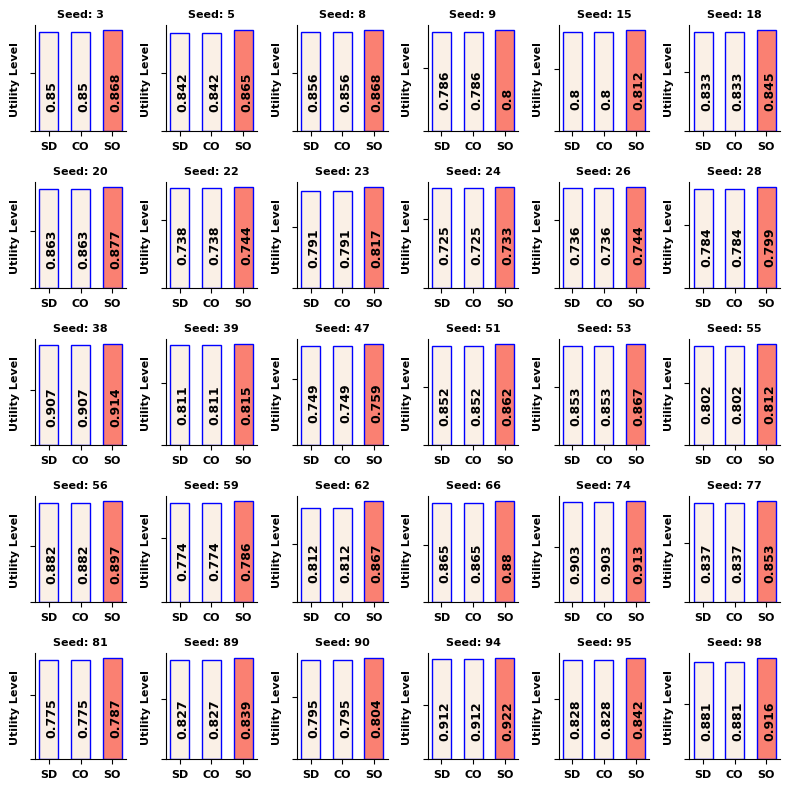

In [27]:

fig, ax = plt.subplots(5,6, figsize = (8,8))

x = range(0,5)
y = range(0,6)
xpos = [1,2,3]
bars = ["SD", "CO", "SO"]

data = 0

for row in x:
    for col in y:
        if Values[data][0] == Values[data][2]:
            ax[row][col].bar(xpos, Values[data], color = "linen", width = 0.60, edgecolor='blue')
            ax[row][col].annotate(str(Values[data][0]), xy = (0.9,0.2), rotation = 90, fontsize = 9, fontweight = "bold")
            ax[row][col].annotate(str(Values[data][1]), xy = (1.9,0.2), rotation = 90, fontsize = 9, fontweight = "bold")
            ax[row][col].annotate(str(Values[data][2]), xy = (2.9,0.2), rotation = 90, fontsize = 9, fontweight = "bold")
        else:
            ax[row][col].bar(xpos, Values[data], color = ["linen", "linen", "salmon"], width = 0.60, edgecolor='blue')
            ax[row][col].annotate(str(Values[data][0]), xy = (0.9,0.2), rotation = 90, fontsize = 9, fontweight = "bold")
            ax[row][col].annotate(str(Values[data][1]), xy = (1.9,0.2), rotation = 90, fontsize = 9, fontweight = "bold")
            ax[row][col].annotate(str(Values[data][2]), xy = (2.9,0.2), rotation = 90, fontsize = 9, fontweight = "bold")
        ax[row][col].set_title("Seed: {}".format(seeds[data]), fontweight = "bold", fontsize = 8)
        ax[row][col].spines['top'].set_visible(False)
        ax[row][col].spines['right'].set_visible(False)
        ax[row][col].set_ylabel("Utility Level", fontsize = 8, fontweight = "bold")
        ax[row][col].set_yticklabels([])
        ax[row][col].set_xticks(xpos)
        ax[row][col].set_xticklabels(bars, fontsize = 8,fontweight = "bold" )
        
        data +=1
plt.tight_layout()

In [28]:
fig.savefig("Algorithm_Simulation_Results_3.png", dpi = 500)

## Market Util (Silme Sonraki Makale İçin)

In [ ]:
sch_prefs = model.school_prefs()
sch_assigns = pd.DataFrame(model.GS_Student_Optimal().iloc[-1])
util_df = pd.DataFrame(index = ["Utility"], columns = sch_prefs.columns)
market_util = 0

for sch in sch_assigns.index:
    sch_pref = list(sch_prefs[sch])
    sch_assign = list(sch_assigns.loc[sch])[0]
    TU = 0
   
    for assign in sch_assign:
        std = assign[0]  
        index = sch_pref.index(std)+1
        util = 1 / index
        TU += util
    
    quota = model.Serial_Dictatorship().loc["Quota", sch]
    average_index = TU / quota
    util_df.loc["Utility", sch] = average_index
    
market_util = np.sum(list(util_df.iloc[0])) / len(sch_prefs.columns)
market_util

0.2875

In [1]:
"codingforfun".split()

['codingforfun']

In [14]:
str[2:6:1]

'RATE'

In [2]:
a = input("Bir sayı giriniz: ")

In [1]:
import numpy as np

arr = np.array([[1, 2, 3], [4, 5, 6]])
#elements from index 1 to 3
print("Range of Elements:",arr[1:4])

#all rows, second column
print("Multidimensional Slicing:", arr[:, 1])


Range of Elements: [[4 5 6]]
Multidimensional Slicing: [2 5]


In [3]:
import numpy as np

# set alias names for dtypes
dtypes = [('name', 'S10'), ('grad_year', int), ('cgpa', float)]

# Values to be put in array
values = [('Hrithik', 2009, 8.5), 
          ('Ajay', 2008, 8.7), 
          ('Pankaj', 2008, 7.9), 
          ('Aakash', 2009, 9.0)]
           
# Creating array
arr = np.array(values, dtype = dtypes)
print ("\nArray sorted by names:\n",
            np.sort(arr, order = 'name'))
            
print ("Array sorted by graduation year and then cgpa:\n",
                np.sort(arr, order = ['grad_year', 'cgpa']))



Array sorted by names:
 [(b'Aakash', 2009, 9. ) (b'Ajay', 2008, 8.7) (b'Hrithik', 2009, 8.5)
 (b'Pankaj', 2008, 7.9)]
Array sorted by graduation year and then cgpa:
 [(b'Pankaj', 2008, 7.9) (b'Ajay', 2008, 8.7) (b'Hrithik', 2009, 8.5)
 (b'Aakash', 2009, 9. )]
